<a href="https://colab.research.google.com/github/dbamman/nlp22/blob/master/AP/BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

BERT for binary or multiclass document classification using the [CLS] token as the document representation; trains a model (on `train.txt`), uses `dev.txt` for early stopping, and evaluates performance on `test.txt`.  Reports test accuracy with 95% confidence intervals.

Before executing this notebook on Colab, make sure you're running on cuda (`Runtime > Change runtime type > GPU`) to make use of GPU speedups.

In [ ]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 34.4 MB/s 
     |████████████████████████████████| 895 kB 54.4 MB/s 
     |████████████████████████████████| 6.6 MB 57.8 MB/s 
     |████████████████████████████████| 77 kB 9.6 MB/s 
     |████████████████████████████████| 596 kB 61.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from transformers import BertModel, BertTokenizer
import nltk
import torch
import torch.nn as nn
import numpy as np
import random
from scipy.stats import norm
import math
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# If you have your folder of data on your Google drive account, you can connect that here
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Change this to the directory with your data
directory="/content/drive/MyDrive/ap_data"

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on {}".format(device))

Running on cuda


In [ ]:
def read_labels(filename):
    labels={}
    with open(filename) as file:
        for line in file:
            cols = line.split("\t")
            label = cols[1]
            if label not in labels:
                labels[label]=len(labels)
    return labels

In [ ]:
def read_data(filename, labels, max_data_points=1000):
  
    data = []
    data_labels = []
    with open(filename) as file:
        for line in file:
            cols = line.split("\t")
            label = cols[1]
            text = cols[2]
            
            data.append(text)
            data_labels.append(labels[label])
            

    # shuffle the data
    tmp = list(zip(data, data_labels))
    random.shuffle(tmp)
    data, data_labels = zip(*tmp)
    
    if max_data_points is None:
        return data, data_labels
    
    return data[:max_data_points], data_labels[:max_data_points]

In [ ]:
labels=read_labels("%s/train.txt" % directory)

In [ ]:
labels

{'1': 1, '2': 2, '3': 0, '4': 3}

In [ ]:
train_x, train_y=read_data("%s/train.txt" % directory, labels, max_data_points=None)

In [ ]:
dev_x, dev_y=read_data("%s/dev.txt" % directory, labels, max_data_points=None)

In [ ]:
test_x, test_y=read_data("%s/test.txt" % directory, labels, max_data_points=None)

In [ ]:
def evaluate(model, x, y):
    model.eval()
    corr = 0.
    total = 0.
    with torch.no_grad():
        for x, y in zip(x, y):
            y_preds=model.forward(x)
            for idx, y_pred in enumerate(y_preds):
                prediction=torch.argmax(y_pred)
                if prediction == y[idx]:
                    corr += 1.
                total+=1                          
    return corr/total, total

In [ ]:
class BERTClassifier(nn.Module):

    def __init__(self, bert_model_name, params):
        super().__init__()
    
        self.model_name=bert_model_name
        self.tokenizer = BertTokenizer.from_pretrained(self.model_name, do_lower_case=params["doLowerCase"], do_basic_tokenize=False)
        self.bert = BertModel.from_pretrained(self.model_name)
        
        self.num_labels = params["label_length"]

        self.fc = nn.Linear(params["embedding_size"], self.num_labels)

    def get_batches(self, all_x, all_y, batch_size=32, max_toks=510):
            
        """ Get batches for input x, y data, with data tokenized according to the BERT tokenizer 
      (and limited to a maximum number of WordPiece tokens """

        batches_x=[]
        batches_y=[]
        
        for i in range(0, len(all_x), batch_size):

            current_batch=[]

            x=all_x[i:i+batch_size]

            batch_x = self.tokenizer(x, padding=True, truncation=True, return_tensors="pt", max_length=max_toks)
            batch_y=all_y[i:i+batch_size]

            batches_x.append(batch_x.to(device))
            batches_y.append(torch.LongTensor(batch_y).to(device))
            
        return batches_x, batches_y
  

    def forward(self, batch_x): 
    
        bert_output = self.bert(input_ids=batch_x["input_ids"],
                         attention_mask=batch_x["attention_mask"],
                         token_type_ids=batch_x["token_type_ids"],
                         output_hidden_states=True)

      # We're going to represent an entire document just by its [CLS] embedding (at position 0)
      # And use the *last* layer output (layer -1)
      # as a result of this choice, this embedding will be optimized for this purpose during the training process.
      
        bert_hidden_states = bert_output['hidden_states']

        out = bert_hidden_states[-1][:,0,:]

        out = self.fc(out)

        return out.squeeze()

In [ ]:
def confidence_intervals(accuracy, n, significance_level):
    critical_value=(1-significance_level)/2
    z_alpha=-1*norm.ppf(critical_value)
    se=math.sqrt((accuracy*(1-accuracy))/n)
    return accuracy-(se*z_alpha), accuracy+(se*z_alpha)

In [ ]:
def train(bert_model_name, model_filename, train_x, train_y, dev_x, dev_y, labels, embedding_size=768, doLowerCase=None):

    bert_model = BERTClassifier(bert_model_name, params={"label_length": len(labels), "doLowerCase":doLowerCase, "embedding_size":embedding_size})
    bert_model.to(device)

    batch_x, batch_y = bert_model.get_batches(train_x, train_y)
    dev_batch_x, dev_batch_y = bert_model.get_batches(dev_x, dev_y)

    optimizer = torch.optim.Adam(bert_model.parameters(), lr=1e-5)
    cross_entropy=nn.CrossEntropyLoss()

    num_epochs=30
    best_dev_acc = 0.
    patience=5

    best_epoch=0

    for epoch in range(num_epochs):
        bert_model.train()

        # Train
        for x, y in zip(batch_x, batch_y):
            y_pred = bert_model.forward(x)
            loss = cross_entropy(y_pred.view(-1, bert_model.num_labels), y.view(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Evaluate
        dev_accuracy, _=evaluate(bert_model, dev_batch_x, dev_batch_y)
        if epoch % 1 == 0:
            print("Epoch %s, dev accuracy: %.3f" % (epoch, dev_accuracy))
            if dev_accuracy > best_dev_acc:
                torch.save(bert_model.state_dict(), model_filename)
                best_dev_acc = dev_accuracy
                best_epoch=epoch
        if epoch - best_epoch > patience:
            print("No improvement in dev accuracy over %s epochs; stopping training" % patience)
            break

    bert_model.load_state_dict(torch.load(model_filename))
    print("\nBest Performing Model achieves dev accuracy of : %.3f" % (best_dev_acc))
    return bert_model


In [ ]:
#small BERT -- can run on laptop
bert_model_name="google/bert_uncased_L-2_H-128_A-2"
model_filename="mybert.model"
embedding_size=128
doLowerCase=True

# bert-base -- slow on laptop; better on Colab
# bert_model_name="bert-base-cased"
# model_filename="mybert.model"
# embedding_size=768
# doLowerCase=False

model=train(bert_model_name, model_filename, train_x, train_y, dev_x, dev_y, labels, embedding_size=embedding_size, doLowerCase=doLowerCase)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/382 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/16.9M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/bert_uncased_L-2_H-128_A-2 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 0, dev accuracy: 0.360
Epoch 1, dev accuracy: 0.380
Epoch 2, dev accuracy: 0.400
Epoch 3, dev accuracy: 0.425
Epoch 4, dev accuracy: 0.430
Epoch 5, dev accuracy: 0.445
Epoch 6, dev accuracy: 0.445
Epoch 7, dev accuracy: 0.460
Epoch 8, dev accuracy: 0.470
Epoch 9, dev accuracy: 0.470
Epoch 10, dev accuracy: 0.470
Epoch 11, dev accuracy: 0.460
Epoch 12, dev accuracy: 0.465
Epoch 13, dev accuracy: 0.475
Epoch 14, dev accuracy: 0.480
Epoch 15, dev accuracy: 0.515
Epoch 16, dev accuracy: 0.525
Epoch 17, dev accuracy: 0.525
Epoch 18, dev accuracy: 0.530
Epoch 19, dev accuracy: 0.540
Epoch 20, dev accuracy: 0.530
Epoch 21, dev accuracy: 0.535
Epoch 22, dev accuracy: 0.525
Epoch 23, dev accuracy: 0.535
Epoch 24, dev accuracy: 0.540
Epoch 25, dev accuracy: 0.540
No improvement in dev accuracy over 5 epochs; stopping training

Best Performing Model achieves dev accuracy of : 0.540


In [ ]:
test_batch_x, test_batch_y = model.get_batches(test_x, test_y)
accuracy, test_n=evaluate(model, test_batch_x, test_batch_y)

lower, upper=confidence_intervals(accuracy, test_n, .95)
print("Test accuracy for best dev model: %.3f, 95%% CIs: [%.3f %.3f]\n" % (accuracy, lower, upper))

Test accuracy for best dev model: 0.610, 95% CIs: [0.542 0.678]



In [ ]:
def evaluate2(model, x, y):
    model.eval()
    corr = 0.
    total = 0.
    preds = []
    with torch.no_grad():
        for x, y in zip(x, y):
            y_preds=model.forward(x)
            for idx, y_pred in enumerate(y_preds):
                prediction=torch.argmax(y_pred)
                preds.append([prediction,y[idx]])
                total+=1                          
    return preds

In [ ]:
preds_tuple =evaluate2(model, test_batch_x, test_batch_y)
preds_tuple = preds_tuple
lst = []
for i in preds_tuple:
  i_0_0 = i[0].item()
  i_1_0 = i[1].item()
  tup = (i_0_0, i_1_0)
  lst.append(tup)
lst
idx_lst = []
for i in range(len(lst)):
  if lst[i][0] != preds_tuple[i][1]:
    idx_lst.append(i)

idx_lst
text_dict = {}
for i in idx_lst:
  text_dict[test_x[i]] = lst[i]
text_dict

{' Maybe try r/52book? I use Goodreads to set my reading goal for the year and track everything. Other than that, I make time to read every day. Usually at night before bed and on lunch breaks. More on the weekends. I read 81 books this year. I was thinking of trying for 100 but that might be a big stretch and I’m afraid I’d try to read only short books, which would limit the books I want to read that are long. I think maybe having a goal based on number of pages read would be neat too. I read less pages in 2021 than I did in 2020, despite that I read two books more in 2021 than I did the previous year.\n': (1,
  2),
 'As far as I know, recommendation requests should go [outside link].\n': (1,
  0),
 "As for alternatives, I don't go here much because I find this sub grating (for reasons that have nothing to do with the moderation), and like, there are SO MANY alternatives out there already. There's /r/writers, /r/PubTips, r/publishing, /r/storyandstyle, /r/YAwriters, /r/fantasywriters,

In [ ]:
lst = []
y_pred_lst = []
y_true_lst = []
for i in preds_tuple:
  i_0_0 = i[0].item()
  i_1_0 = i[1].item()
  tup = (i_0_0, i_1_0)
  y_pred_lst.append(i_0_0)
  y_true_lst.append(i_1_0)
  lst.append(tup)
np.array(y_pred_lst),np.array(y_true_lst)

(array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0,
        1, 2, 0, 1, 2, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 2, 0, 0, 2, 1, 1,
        1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 0, 1,
        2, 1, 0, 1, 1, 1, 0, 2, 2, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0,
        1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 2, 1, 0, 0, 0,
        1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 2, 0, 1, 1, 1,
        1, 0, 2, 1, 2, 1, 1, 1, 0, 1, 0, 1, 0, 1, 2, 0, 1, 0, 1, 0, 0, 1,
        1, 1, 1, 1, 2, 0, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 0, 2, 2, 1,
        0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1]),
 array([1, 1, 0, 1, 2, 2, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 2, 0, 2, 0,
        1, 0, 0, 2, 0, 0, 1, 1, 1, 1, 1, 0, 1, 2, 0, 0, 0, 0, 3, 2, 1, 2,
        2, 0, 0, 2, 1, 0, 1, 1, 1, 0, 2, 1, 1, 1, 2, 1, 1, 0, 1, 0, 0, 1,
        2, 1, 0, 1, 1, 2, 0, 3, 2, 1, 0, 1, 1, 0, 2, 1, 1, 2, 2, 2, 0, 0,
        2, 3, 1, 1, 0,

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd


In [ ]:
labels

{'1': 1, '2': 2, '3': 0, '4': 3}

Text(33.0, 0.5, 'True labels')

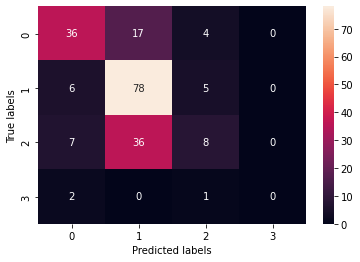

In [ ]:
#df = pd.DataFrame({'true_y':y_true_lst, 'pred_y':y_pred_lst})
sns.heatmap(confusion_matrix(np.array(y_true_lst), np.array(y_pred_lst)), annot = True, fmt = 'd')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')